#**USO DE MODELOS CNN PREFABRICADOS**

###**VGG16 CON CIFAR-10**

In [ ]:
# CLASIFICACIÓN DE IMÁGENES USANDO VGG16 (TRANSFER LEARNING)

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# 1. Cargar dataset CIFAR-10
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Convertir etiquetas a one-hot
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)

# Redimensionar imágenes a 224x224 para VGG16
X_train_resized = tf.image.resize(X_train, (224, 224))
X_test_resized  = tf.image.resize(X_test, (224, 224))

# Preprocesamiento requerido por VGG16
X_train_resized = preprocess_input(X_train_resized)
X_test_resized  = preprocess_input(X_test_resized)

# 2. Cargar modelo base VGG16 sin capa superior
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Congelar capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# 3. Crear el modelo final añadiendo nuestras capas
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# 4. Entrenar el modelo
history = model.fit(
    X_train_resized, y_train,
    validation_data=(X_test_resized, y_test),
    epochs=5,
    batch_size=32
)

# 5. Graficar métricas
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Precisión VGG16")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend(["Entrenamiento", "Validación"])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Pérdida VGG16")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend(["Entrenamiento", "Validación"])
plt.show()

# 6. Evaluación final
test_loss, test_acc = model.evaluate(X_test_resized, y_test, verbose=0)
print(f"\nPrecisión final en test: {test_acc:.4f}")


###**INCEPTION V3 CON CIFAR-10**

In [ ]:
# CLASIFICACIÓN DE IMÁGENES USANDO INCEPTIONV3 (TRANSFER LEARNING)

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# 1. Cargar dataset CIFAR-10
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test  = tf.keras.utils.to_categorical(y_test, 10)

# Redimensionar a 299x299 para InceptionV3
X_train = tf.image.resize(X_train, (299,299))
X_test  = tf.image.resize(X_test,  (299,299))

# Preprocesamiento específico de Inception
X_train = preprocess_input(X_train)
X_test  = preprocess_input(X_test)

# 2. Cargar modelo base InceptionV3 sin la parte superior
base = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))

# Congelar capas del modelo base
for layer in base.layers:
    layer.trainable = False

# 3. Añadir nuestras capas superiores
x = GlobalAveragePooling2D()(base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base.input, outputs=output)

# Compilar modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# 4. Entrenar modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=32
)

# 5. Graficar métricas
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Precisión InceptionV3")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend(["Entrenamiento", "Validación"])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Pérdida InceptionV3")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend(["Entrenamiento", "Validación"])
plt.show()

# 6. Evaluación final
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nPrecisión final (test): {acc:.4f}")


###**Este Modelo asi consume mucha memoria RAM:**

**El código hace esto:**

1. Carga CIFAR-10 (60,000 imágenes)

2. Cada imagen se redimensiona de 32×32×3 → 299×299×3

**Eso aumenta el tamaño de memoria 87 veces.**

**Luego las guardas todas en RAM como tensores**

**Y TensorFlow además crea:**

* Copias internas

* Versiones para gradientes

* Buffers de entrenamiento

**Así que terminamos con algo como:**

60,000 × 299 × 299 × 3 × 4 bytes ≈ 19.2 GB solo en imágenes



####**Por ello aca tenemos una version mas ligera**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Función para redimensionar de forma eficiente
def preprocess(image, label):
    image = tf.image.resize(image, (299, 299))        # redimensiona SÓLO la imagen actual
    image = preprocess_input(image)                   # normaliza según Inception
    label = tf.one_hot(label, 10)
    return image, tf.squeeze(label)

# Cargar CIFAR-10
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Crear datasets dinámicos (no cargan todo en RAM)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Aplicar preprocesamiento sin copiar todo en memoria
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

# Cargar el modelo base
base = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))

for layer in base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(10, activation='softmax')(x)

model = Model(base.input, output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=test_ds, epochs=5)

loss, acc = model.evaluate(test_ds)
print("Accuracy en test:", acc)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
  45/1563 ━━━━━━━━━━━━━━━━━━━━ 2:53:23 7s/step - accuracy: 0.3445 - loss: 1.8902

KeyboardInterrupt: 

**Version de aprox 4GB RAM para VSCode**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# 1. Cargar dataset CIFAR-10
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# One-hot
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test  = tf.keras.utils.to_categorical(y_test, 10)

# Redimensionar a 224x224 (MobileNetV2)
X_train = tf.image.resize(X_train, (224, 224))
X_test  = tf.image.resize(X_test,  (224, 224))

# Preprocesar
X_train = preprocess_input(X_train)
X_test  = preprocess_input(X_test)

# 2. Cargar MobileNetV2 sin la parte superior
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Congelar capas
for layer in base.layers:
    layer.trainable = False

# 3. Capas superiores
x = GlobalAveragePooling2D()(base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base.input, outputs=output)

# Compilar
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# 4. Entrenamiento
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=32
)

# 5. Gráficas
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Precisión MobileNetV2")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend(["Entrenamiento", "Validación"])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Pérdida MobileNetV2")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend(["Entrenamiento", "Validación"])
plt.show()

# 6. Evaluación
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nPrecisión final (test): {acc:.4f}")

#**TABLAS DE EVALUACION**

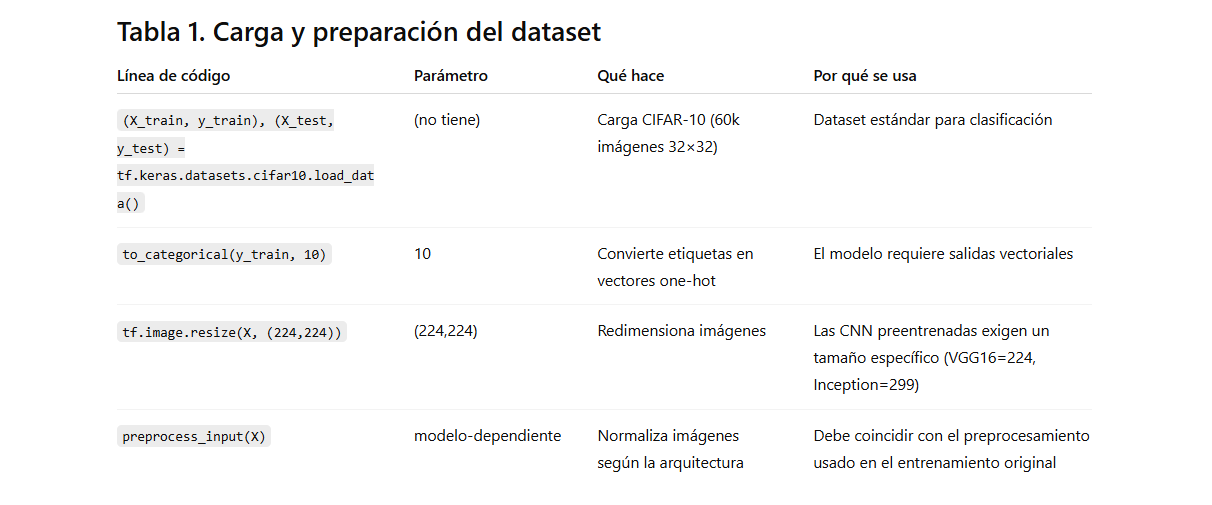

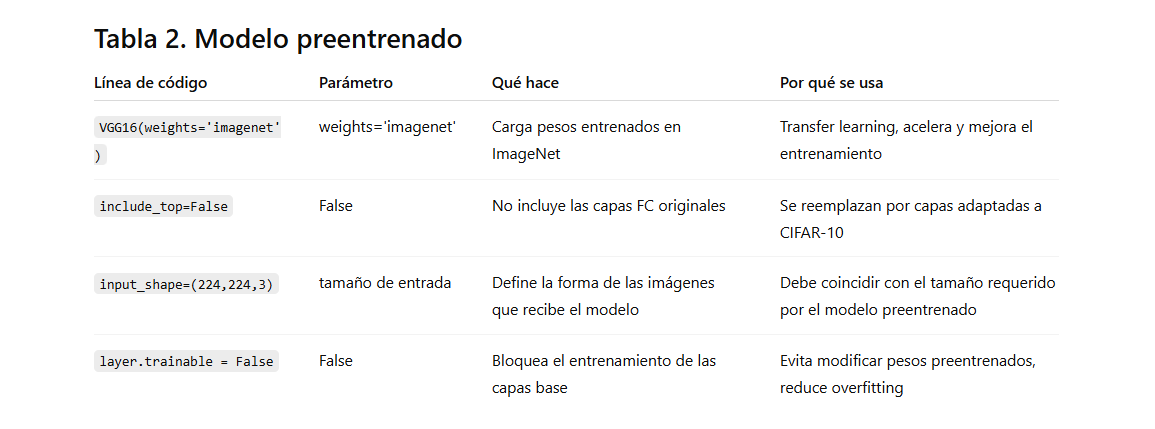

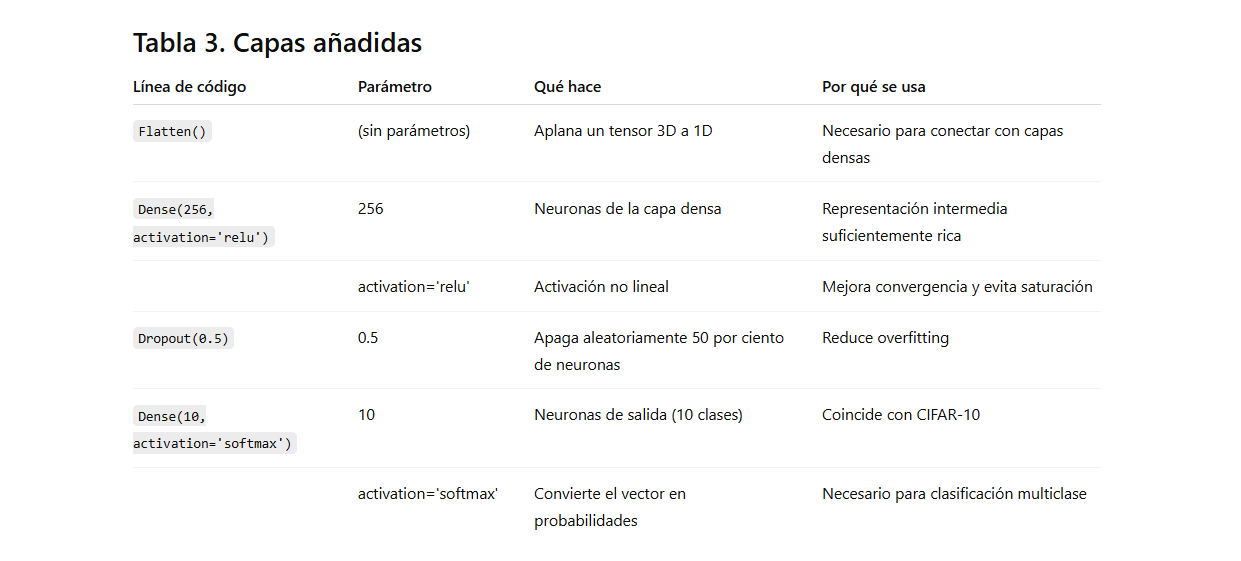

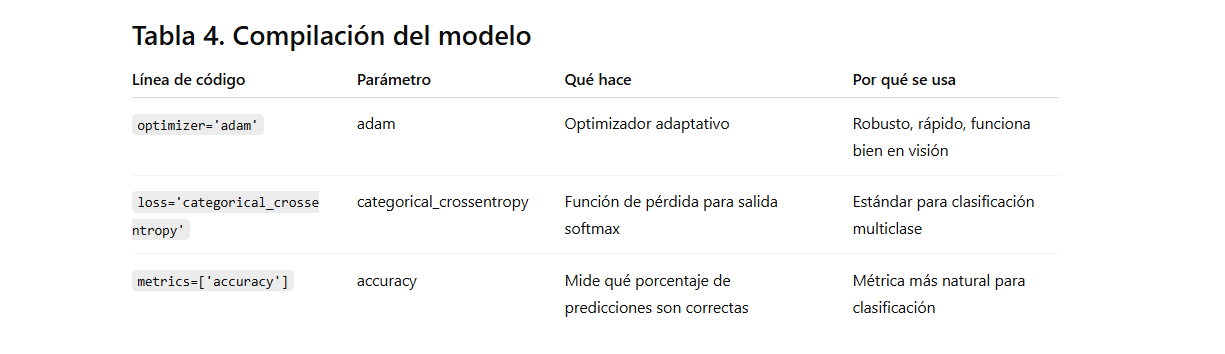

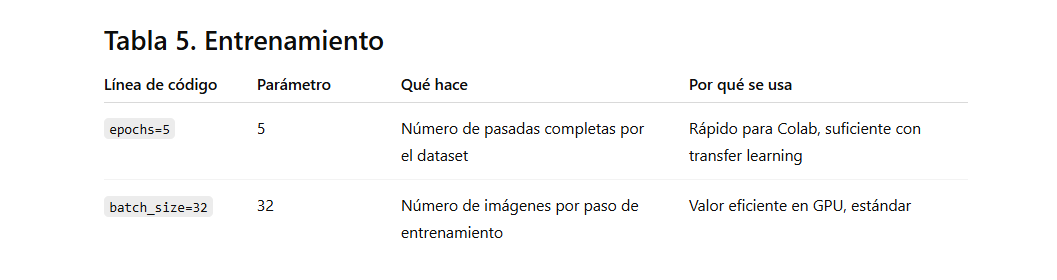

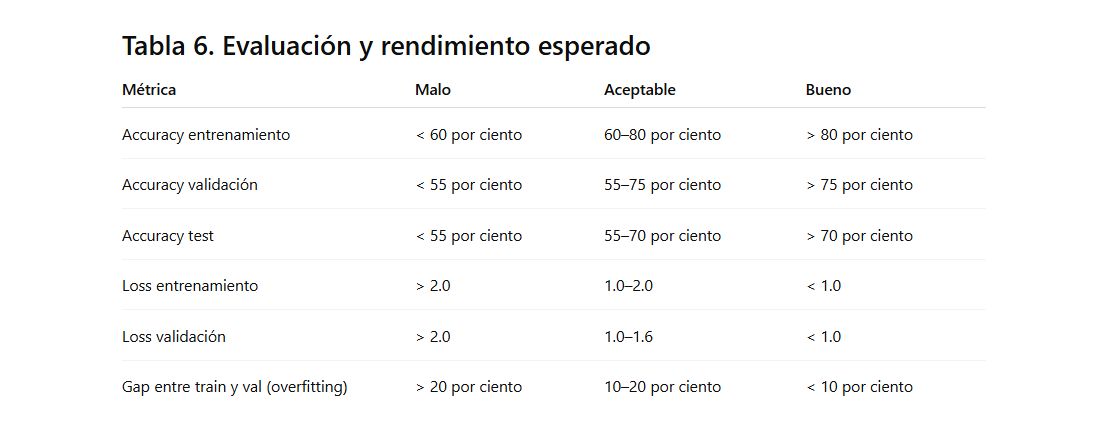